In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
from keras.models import Sequential, Model, load_model
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [71]:


import os
def make_dir_label_dataframe(path,keyword):

    class_folders = os.listdir(path)
    image_paths = []
    labels = []

    for class_folder in class_folders:
        for key in keyword:
            if key in class_folder:
                class_path = os.path.join(path, class_folder)
                image_files = os.listdir(class_path)
                for image_file in image_files:
                    image_path = os.path.join(class_path, image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    return  image_paths,labels
                    


Getting keywords for dataframe

In [72]:
import os
path = "/kaggle/input/face-mask-dataset/data"
keyword=[]
for key in os.listdir(path) :
    keyword.append(key)
    print(key)
    

without_mask
with_mask


In [73]:
image,label=make_dir_label_dataframe(path,keyword)

In [74]:
import pandas as pd
df = pd.DataFrame({'image_path': image, 'label': label})
df.head(10)

,image_path,label
0,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
1,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
2,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
3,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
4,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
5,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
6,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
7,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
8,/kaggle/input/face-mask-dataset/data/without_m...,without_mask
9,/kaggle/input/face-mask-dataset/data/without_m...,without_mask


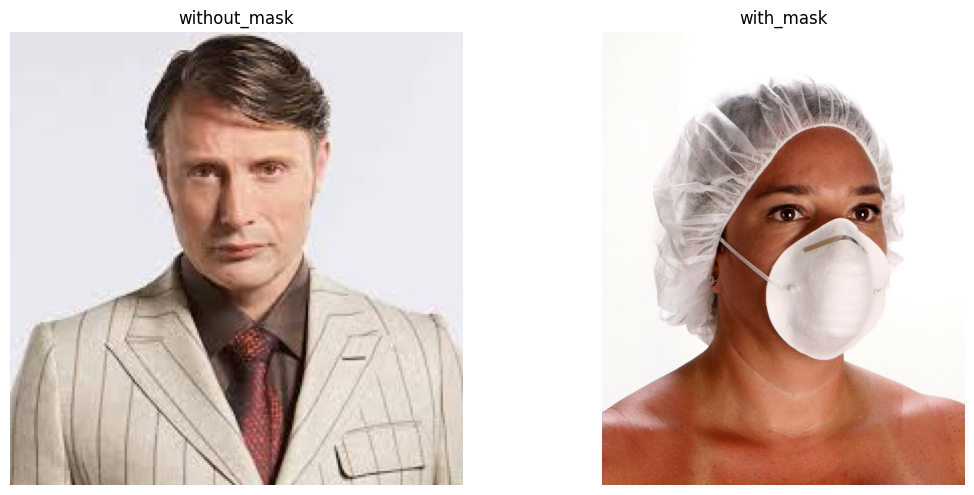

In [75]:

import cv2
import matplotlib.pyplot as plt

def Disply():
    plt.figure(figsize=(20,20))
    for i, class_name in enumerate(keyword):
        plt.subplot(3, 3, i + 1)

        img_RGB= cv2.imread(df[df['label']==class_name]['image_path'].iloc[1])
        if img_RGB is not None:
            plt.imshow(cv2.cvtColor(img_RGB, cv2.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')


plt.show()

Disply()



In [76]:
class_counts = df['label'].value_counts()
print(class_counts)



label
without_mask    3828
with_mask       3725
Name: count, dtype: int64


In [77]:
size_list=[]
for size in class_counts:
    size_list.append(size)

size_list

[3828, 3725]

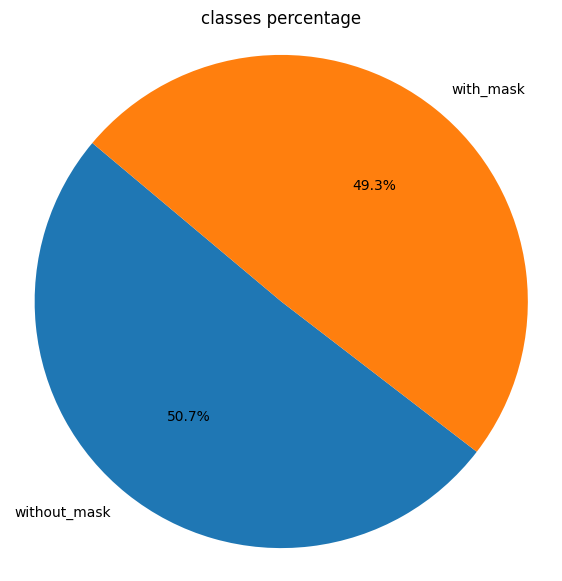

In [78]:


import matplotlib.pyplot as plt


labels = keyword
sizes = size_list

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title("classes percentage")

plt.axis('equal')
plt.show()



In [79]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [81]:


train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 4834 validated image filenames belonging to 2 classes.
Found 1208 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


In [82]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1.0 / 255),  
])

In [83]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [84]:
batch_size=32
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch = len(train_images)//batch_size,

    validation_data=val_images,
    validation_steps = len(val_images)//batch_size, 
    epochs=5,

)



Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5917 - loss: 0.7497 - val_accuracy: 0.8125 - val_loss: 0.3494
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step - accuracy: 0.7708 - loss: 0.4032 - val_accuracy: 0.9375 - val_loss: 0.1573
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 860ms/step - accuracy: 0.9490 - loss: 0.1562 - val_accuracy: 1.0000 - val_loss: 0.0429
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 833ms/step - accuracy: 0.9802 - loss: 0.0860 - val_accuracy: 0.9688 - val_loss: 0.0498
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 928ms/step - accuracy: 0.9781 - loss: 0.0636 - val_accuracy: 0.9688 - val_loss: 0.0588


In [85]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07170
Test Accuracy: 97.35%


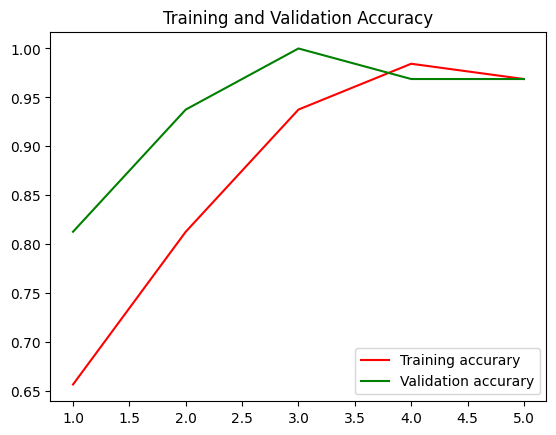

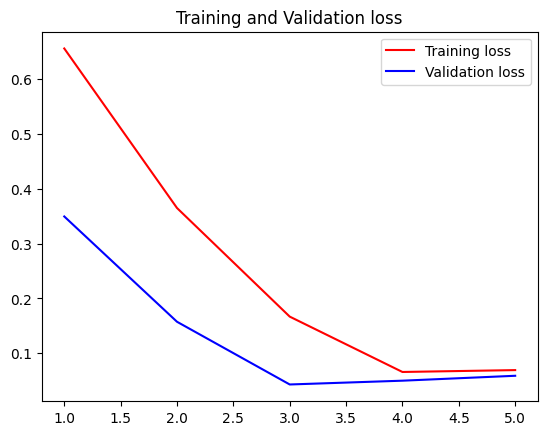

In [89]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'r',label='Training accurary')
plt.plot(epochs,val_acc,'g',label='Validation accurary')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

